In [117]:
# %%
# 1. 依赖
import torch
import numpy as np
from matplotlib import pyplot as plt

print("PyTorch version:", torch.__version__)

PyTorch version: 2.7.1+cpu


In [118]:
# %%
# 2. 载入 CIFAR-10 数据（包含 10 类 32×32 彩色图）
from torchvision import datasets, transforms
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),                  # 含 /255 归一化
])
test_tfms = transforms.ToTensor()
# CIFAR 的 .data 属性是 numpy 数组，形状 (N, 32, 32, 3)
train_dataset = datasets.CIFAR10(root='./data', train=True,  download=True)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True)

train_images, train_labels = train_dataset.data, train_dataset.targets
test_images , test_labels  = test_dataset.data , test_dataset.targets

Train images shape: (50000, 32, 32, 3)
Train labels shape: 50000


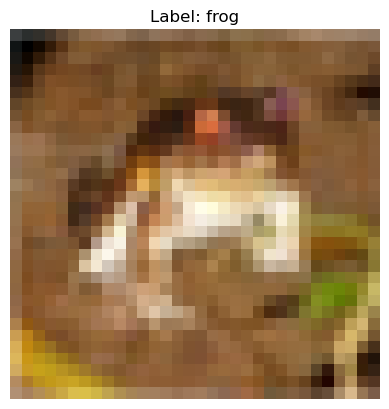

In [119]:
# %%
# 3. 数据概览 —— 查看形状 / 标签 / 一张示例图
print("Train images shape:", train_images.shape)   # (50000, 32, 32, 3)
print("Train labels shape:", len(train_labels))    # 50000
class_names = train_dataset.classes                # ['airplane', 'automobile', …]

plt.figure()
plt.imshow(train_images[0])        # 直接可视化
plt.title(f"Label: {class_names[train_labels[0]]}")
plt.axis(False)
plt.show()

In [120]:
# %%
# 4. 预处理与 DataLoader
#    (a) 归一化到 [0,1] 并转为 torch.float32
#    (b) 调整通道顺序 (H,W,C) → (C,H,W) 以符合 PyTorch
#    (c) 打包为 TensorDataset，再用 DataLoader

# helper：numpy → tensor，并归一化
def np_to_tensor(images_np):
    imgs = torch.from_numpy(images_np).permute(0, 3, 1, 2)     # (N,3,32,32)
    imgs = imgs.float() / 255.0                                # 0-1
    return imgs

train_images_t = np_to_tensor(train_images)
test_images_t  = np_to_tensor(test_images)

train_labels_t = torch.tensor(train_labels, dtype=torch.long)
test_labels_t  = torch.tensor(test_labels , dtype=torch.long)

from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(train_images_t, train_labels_t),
                          batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(test_images_t , test_labels_t ),
                          batch_size=batch_size, shuffle=False)

In [121]:
# %%
# 5. 构建一个简单 CNN
import torch.nn as nn

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        # ---------- 卷积块 ----------
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # 3 → 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32 → 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 64 → 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2, 2)

        # ---------- 全连接 ----------
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(nn.Linear(64*8*8, 128),nn.ReLU(inplace=True),nn.Dropout(0.5))
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))  # Conv1 → BN → ReLU → Pool
        x = self.pool(self.conv2(x))  # Conv2 → BN → ReLU → Pool
        x = self.conv3(x)             # Conv3 → BN → ReLU
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = CIFAR10Model().to(device)

In [122]:
# %%
# 6. 优化器、损失函数、准确率指标
import torch.optim as optim
from torchmetrics import Accuracy

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.CrossEntropyLoss()
acc_metric = Accuracy(task="multiclass", num_classes=10)

In [123]:
# %%
# 7. 训练单个 epoch 的函数
def train_epoch(model, loader, optimizer, loss_fn, acc_metric, device):
    model.train()
    epoch_loss = epoch_acc = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)
        preds = outputs.argmax(1)
        epoch_acc += acc_metric(preds.cpu(), y.cpu()) * x.size(0)
    size = len(loader.dataset)
    return epoch_loss/size, epoch_acc/size

In [124]:
# %%
# 8. 测试函数
def evaluate(model, loader, loss_fn, acc_metric, device):
    model.eval()
    epoch_loss = epoch_acc = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = loss_fn(outputs, y)

            epoch_loss += loss.item() * x.size(0)
            preds = outputs.argmax(1)
            epoch_acc += acc_metric(preds.cpu(), y.cpu()) * x.size(0)
    size = len(loader.dataset)
    return epoch_loss/size, epoch_acc/size

In [125]:
# %%
# 9. 训练循环
num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader,
                                        optimizer, loss_fn, acc_metric, device)
    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

Epoch  1/50 | Train Loss: 1.4332 | Train Acc: 0.4820
Epoch  2/50 | Train Loss: 1.1226 | Train Acc: 0.6012
Epoch  3/50 | Train Loss: 0.9894 | Train Acc: 0.6494
Epoch  4/50 | Train Loss: 0.9099 | Train Acc: 0.6807
Epoch  5/50 | Train Loss: 0.8424 | Train Acc: 0.7060
Epoch  6/50 | Train Loss: 0.7976 | Train Acc: 0.7210
Epoch  7/50 | Train Loss: 0.7423 | Train Acc: 0.7396
Epoch  8/50 | Train Loss: 0.7008 | Train Acc: 0.7539
Epoch  9/50 | Train Loss: 0.6634 | Train Acc: 0.7665
Epoch 10/50 | Train Loss: 0.6341 | Train Acc: 0.7763
Epoch 11/50 | Train Loss: 0.5933 | Train Acc: 0.7883
Epoch 12/50 | Train Loss: 0.5668 | Train Acc: 0.7978
Epoch 13/50 | Train Loss: 0.5373 | Train Acc: 0.8104
Epoch 14/50 | Train Loss: 0.5085 | Train Acc: 0.8209
Epoch 15/50 | Train Loss: 0.4844 | Train Acc: 0.8273
Epoch 16/50 | Train Loss: 0.4606 | Train Acc: 0.8346
Epoch 17/50 | Train Loss: 0.4370 | Train Acc: 0.8410
Epoch 18/50 | Train Loss: 0.4201 | Train Acc: 0.8474
Epoch 19/50 | Train Loss: 0.4020 | Train Acc: 

In [126]:
# %%
# 10 评估
test_loss, test_acc = evaluate(model, test_loader,
                               loss_fn, acc_metric, device)
print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.4f}")

Test  Loss: 1.1367 | Test  Acc: 0.7824


In [127]:
# %%
# 11. Softmax 概率，用于可视化
probability_model = nn.Sequential(model, nn.Softmax(dim=1)).eval()

with torch.no_grad():
    test_probs = probability_model(test_images_t.to(device)).cpu().numpy()

In [128]:
# %%
# 12. 可视化函数（与 Fashion-MNIST 部分一致）
def plot_image(i, probs, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(img)
    pred = np.argmax(probs)
    color = 'blue' if pred == true_label else 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[pred],
               100*np.max(probs), class_names[true_label]), color=color)

def plot_value_array(i, probs, true_label):
    true_label = true_label[i]
    plt.grid(False); plt.xticks(range(10)); plt.yticks([])
    bars = plt.bar(range(10), probs, color="#777777")
    plt.ylim([0, 1])
    pred = np.argmax(probs)
    bars[pred].set_color('red')
    bars[true_label].set_color('blue')

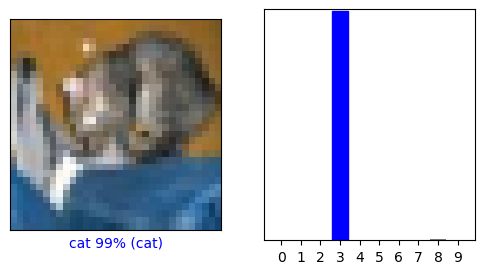

In [129]:
# %%
# 13. 单张预测示例
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plot_image(i, test_probs[i], test_labels, test_images)
plt.subplot(1,2,2); plot_value_array(i, test_probs[i], test_labels)
plt.show()

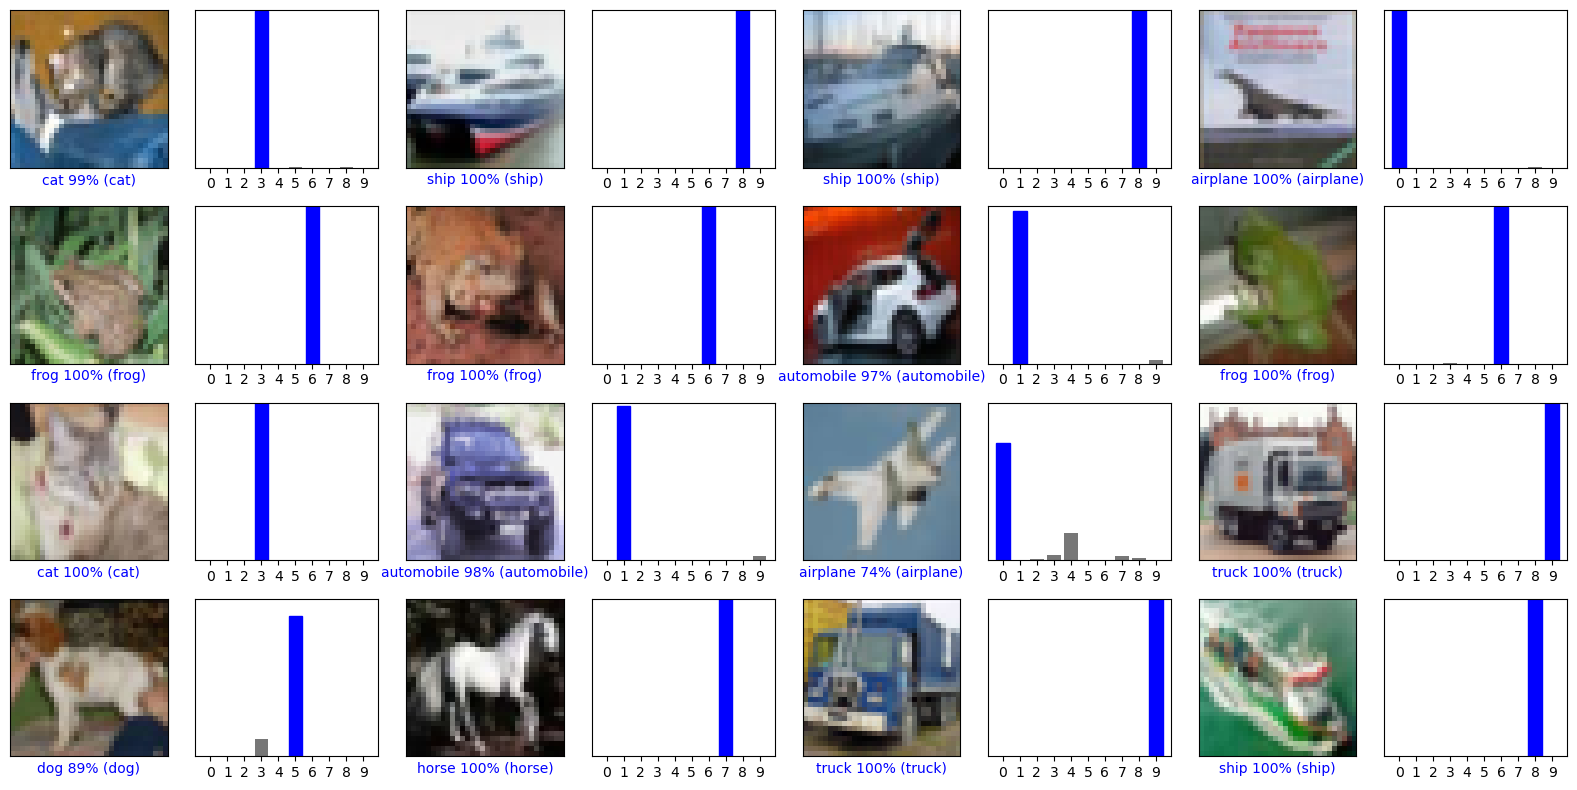

In [130]:
# %%
# 14. 多张可视化
num_rows, num_cols = 4, 4
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_probs[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_probs[i], test_labels)
plt.tight_layout()
plt.show()